In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

# %matplotlib widget

In [2]:
class Jackknife:
    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def __init__( self, nbins, binsize, binned ):
        self.binsize = binsize
        self.nbins = nbins
        self.N = self.binsize * self.nbins
        self.binned = binned
        self.jack_avg = []
        self.est = 0
        self.var_est = 0
        
        for i in range( 0, self.nbins ):
            resmpld = np.delete(binned, i, 0)
            self.jack_avg.append( np.mean(resmpld, 0) )
            
        self.do_it()

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)
    
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [3]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [4]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return -coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

In [5]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [6]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

In [7]:
def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

In [8]:
def TTconn(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

In [9]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

In [10]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

In [11]:
def ZI( nu ):
    res = 0.0
    
    for nup in range(1, 5):
        if nup == nu: continue
        else: res += ZM(nup)

    res -= ZM(nu)
    res *= 0.5
    
    return res

In [12]:
def ZMss_nu(z, nu):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = np.abs( th1(z) )**(1/4)
    
    if nu==1: numer=np.abs( th1(0.5*z) )
    elif nu==2: numer=np.abs( th2(0.5*z) )
    elif nu==3: numer=np.abs( th3(0.5*z) )
    elif nu==4: numer=np.abs( th4(0.5*z) )
    else: assert(false)
    
    return factor * numer/denom

In [13]:
def ZMtot():
    res = 0.0
    for nup in range(1, 5):
        res += ZM(nup)
    return res

In [14]:
def ss_corr_analytic(z):
    res = 0.0
    for nu in range(1,5):
        res += ZMss_nu( z,nu )

    res /= ZMtot()
    
    return res

In [15]:
def epseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * np.abs( P2(z) )**2
    res += ZM( 3 ) * np.abs( P3(z) )**2
    res += ZM( 4 ) * np.abs( P4(z) )**2

    res /= ZMtot()
    
    return res

In [16]:
# Lx = 72 # 72 # 384 # 768 # 1536
# Ly = 2*Lx
Lx = 3 # 72 # 384 # 768 # 1536
Ly = 3

tau = Ly/Lx*np.exp( 1.0j*np.pi/3 )

Nbintot = 104
binsize = 1e3
# Nbintot = 4
# binsize = 1e2

nskip = 4
Nbin = Nbintot-nskip

In [17]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

In [18]:
directory1="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1/"

In [19]:
ss0 = np.array([np.loadtxt(directory1+"ss_even0_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [20]:
np.mean(ss0)

0.8849871794871803

## $\sigma\sigma$

In [22]:
ss_corr1 = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

# directory2="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu2/"
# directory3="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu3/"
# directory4="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu4/"
# ss_corr2 = np.array([np.loadtxt(directory2+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# ss_corr3 = np.array([np.loadtxt(directory3+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
# ss_corr4 = np.array([np.loadtxt(directory4+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [23]:
jk1 = Jackknife( Nbin, binsize, ss_corr1[nskip:] )
# jk2 = Jackknife( Nbin, binsize, ss_corr2[nskip:] )
# jk3 = Jackknife( Nbin, binsize, ss_corr3[nskip:] )
# jk4 = Jackknife( Nbin, binsize, ss_corr4[nskip:] )

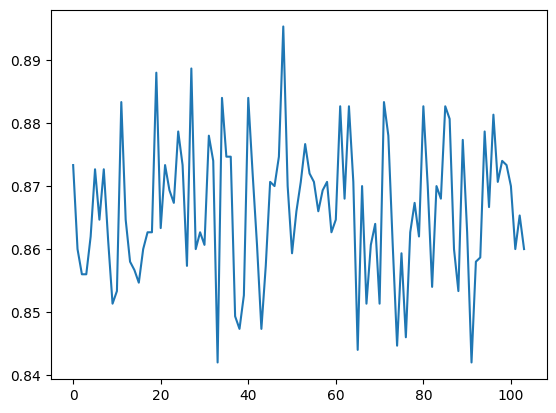

In [24]:
plt.close()
plt.plot(ss_corr1[:,1,1])

In [25]:
shape = jk1.mean().shape
jkm = jk1.mean()
jke = jk1.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [26]:
# shape = jk2.mean().shape
# jkm = jk2.mean()
# jke = jk2.err()
# tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

# tmp2 = tmp.flatten()
# ss2=np.array(np.split(tmp2, tmp2.shape[0]/4))

# shape = jk3.mean().shape
# jkm = jk3.mean()
# jke = jk3.err()
# tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

# tmp2 = tmp.flatten()
# ss3=np.array(np.split(tmp2, tmp2.shape[0]/4))

# shape = jk4.mean().shape
# jkm = jk4.mean()
# jke = jk4.err()
# tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

# tmp2 = tmp.flatten()
# ss4=np.array(np.split(tmp2, tmp2.shape[0]/4))

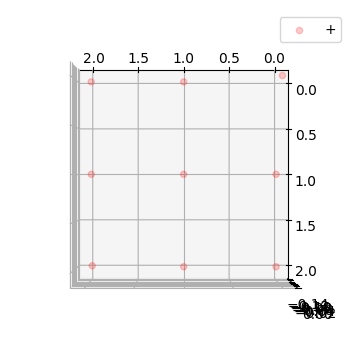

In [27]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [28]:
# t = 0

# yt = ss1[t*Lx:(t+1)*Lx]

# # fac = 4.05
# # fac = 0.29

# plt.close()
# plt.errorbar( np.log(yt.T[0]/Lx), np.log( yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

# x = np.arange(-5, 1)
# y = -1.4 - 1.0/4.0 * x
# plt.plot( x, y )

In [23]:
kappa = 2.0/3.0
cos = np.cos( np.pi/6.0 )
B = cos / ( 1.0 - kappa**2 * cos**2 )
alat = 1.0/Lx

In [24]:
# u = np.sqrt( 3.0/alat**0.25 / (sxA[2]+sxB[2]+sxC[2]) )
# u = np.sqrt( 3.0/alat**0.25 * 0.5*kappa*B )
u = np.sqrt( 3.0/alat**0.25 * 0.5*kappa*B )

In [34]:
np.mean(ss0) * kappa*B * 3 / 2.0

1.149632069189155

In [31]:
t = int(Ly/16)-1

yt = ss1[t*Lx:(t+1)*Lx]

fac = u**2
# fac = 3.4
# fac = 4.05
# fac = 0.29

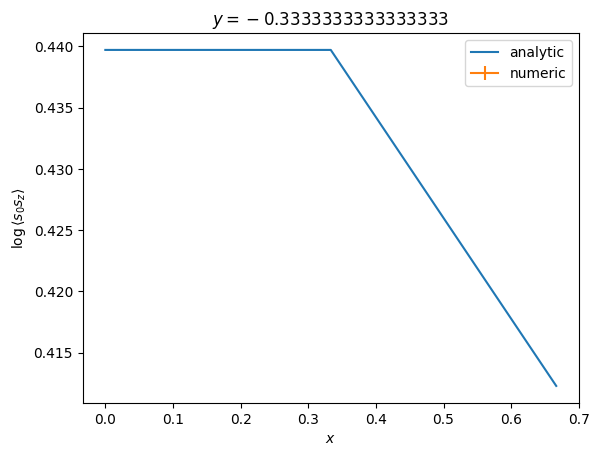

In [32]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [ss_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( yt.T[0]/Lx, np.log( fac * yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
# plt.ylim( 0.0, 1.0 )

# plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.savefig('./ss_yslice.pdf',bbox_inches='tight')

In [33]:
t = int(Ly/32)-1
xt = ss1[t::Lx]

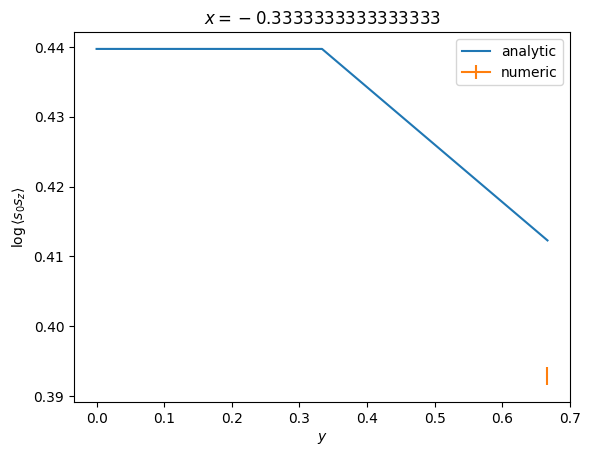

In [34]:
plt.close()

x = np.arange(0, Ly)/Ly
y = np.array( [ss_corr_analytic( t/Lx + tau*yy ) for yy in x] )

plt.plot( x, np.log(y), label="analytic" )
plt.errorbar( xt.T[1]/Ly, np.log(fac * xt.T[2]), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
# plt.ylim( -1.0, 0.0 )

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

plt.savefig('./ss_xslice.pdf',bbox_inches='tight')

## $\varepsilon \varepsilon$

In [35]:
eps_1pt = np.array([np.loadtxt(directory1+"eps_1pt_"+str(i)+".dat") for i in range(1, Nbintot+1)])
epseps_corr1 = np.array([np.loadtxt(directory1+"epseps_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

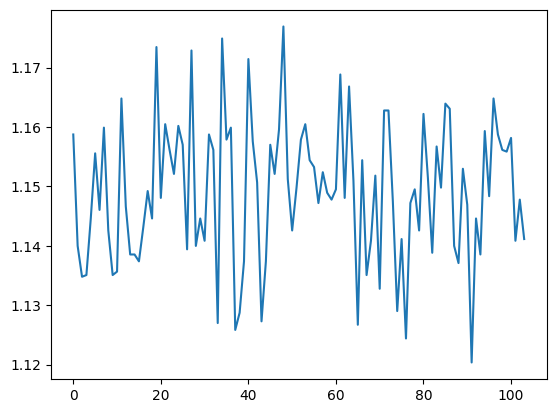

In [36]:
plt.close()
plt.plot(eps_1pt)

In [37]:
directory1

'./data_Lx3Ly3nu1/'

In [38]:
(eps_1pt**2).shape

(104,)

In [39]:
epseps_corr1.shape

(104, 3, 3)

In [40]:
np.mean( eps_1pt )

1.1491213362587276

In [41]:
1.00004823e+00

1.00004823

In [42]:
eps_1pt

array([1.15874199, 1.13997811, 1.13478195, 1.13507063, 1.14459691,
       1.15556656, 1.14604028, 1.15989669, 1.14257618, 1.13507063,
       1.13564798, 1.16480417, 1.14661763, 1.13853473, 1.13853473,
       1.13738003, 1.14315353, 1.14921571, 1.14459691, 1.17346442,
       1.14806101, 1.16047404, 1.15614391, 1.15210246, 1.16018537,
       1.15700994, 1.13940076, 1.17288707, 1.13997811, 1.14459691,
       1.14084413, 1.15874199, 1.15614391, 1.12698773, 1.1749078 ,
       1.15787596, 1.15989669, 1.12583302, 1.12871978, 1.13738003,
       1.1714437 , 1.15758729, 1.15065909, 1.1272764 , 1.13738003,
       1.15700994, 1.15210246, 1.15960802, 1.17692852, 1.15123644,
       1.14257618, 1.14979306, 1.15787596, 1.16047404, 1.15441186,
       1.15325716, 1.14719498, 1.15239114, 1.14892704, 1.14777234,
       1.14950439, 1.16884562, 1.14806101, 1.16682489, 1.15094776,
       1.12669905, 1.15441186, 1.13507063, 1.14084413, 1.15181379,
       1.13276123, 1.16278344, 1.16278344, 1.14748366, 1.12900

In [58]:
subt = np.mean(eps_1pt[nskip:])-1.0

In [40]:
epseps_conn = np.array([ epseps_corr1[i]-eps_1pt[i]**2 for i in range(Nbintot)])

In [41]:
jk1 = Jackknife( Nbin, binsize, epseps_corr1[nskip:] )
jk = Jackknife( Nbin, binsize, epseps_conn[nskip:] )

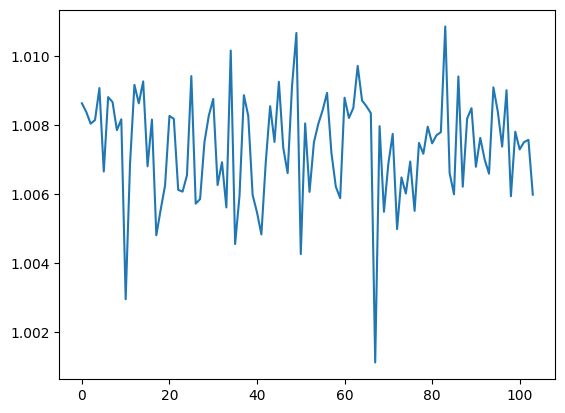

In [42]:
plt.close()
plt.plot(epseps_corr1[:,int(Lx/2),int(Lx/2)])

In [43]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

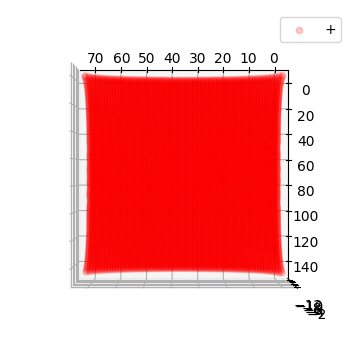

In [44]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [45]:
# t = 0

# yt = ss1[t*Lx:(t+1)*Lx]

# # fac = 4.05
# # fac = 0.29

# plt.close()
# plt.errorbar( np.log(yt.T[0]/Lx), np.log( yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

# x = np.arange(-5, 1)
# y = -1.4 - 1.0/4.0 * x
# plt.plot( x, y )

In [47]:
t = int(Ly/24)-1

yt = ss1[t*Lx:(t+1)*Lx]

# fac = 3.4
# fac = 4.05
# fac = 0.29

In [48]:
alat = 1.0/Lx
r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

In [23]:
kappa = 2.0/3.0

In [24]:
cos = np.cos( np.pi/6.0 )
B = cos / ( 1.0 - kappa**2 * cos**2 )

In [51]:
fac2 = 9.0/4.0 * kappa**2 * B**2 * (2.0*np.pi)**2 / r**4

In [67]:
subt

0.0035990570805810584

In [55]:
eta = dedekind( tau )
sumTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
analytic = 2.0 * np.pi * np.abs(eta)**3 / sumTh

In [56]:
analytic

0.6414227913833944

In [66]:
(2.0*np.pi) * subt / r**2

0.626684874681656

In [25]:
kappa*B

0.8660254037844385

In [ ]:
kappa*B * 

In [ ]:
dnm = th

In [143]:
eta

(0.6137688716634091+0.16445887350157182j)

In [149]:
2.0*np.pi * np.abs(eta)**3 / sumTh

0.6414227913833944

In [151]:
kappa*B

0.8660254037844385

In [155]:
2.0*np.pi / r

33.07654760537591

In [156]:
3.0/2.0 * kappa*B * np.mean(eps_1pt) * 2.0*np.pi / r**2

174.69658877504887

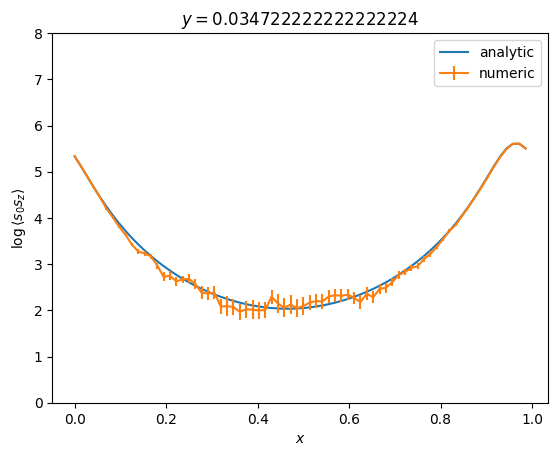

In [50]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

# x = np.arange(0, Lx)/Lx
# y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
# plt.plot( x, np.log(y), label="analytic" )

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( fac2*yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 8.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.show()
# plt.savefig('./yslice.pdf',bbox_inches='tight')

In [55]:
t = int(Ly/24)-1
xt = ss1[t::Lx]

/tmp/ipykernel_24993/1063696738.py:7: RuntimeWarning: invalid value encountered in log
  plt.errorbar( xt.T[1]/Ly, np.log( fac2*xt.T[2] ), np.abs(xt.T[3]/xt.T[2]), label="numeric" )


Text(0, 0.5, '$\\log\\langle s_0 s_z\\rangle $')

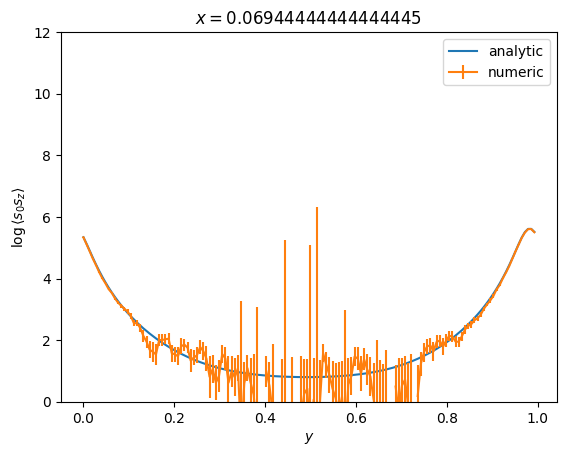

In [60]:
plt.close()

x = np.arange(0, Ly)/Ly
y = np.array( [epseps_corr_analytic( t/Lx + tau*yy ) for yy in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( xt.T[1]/Ly, np.log( fac2*xt.T[2] ), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
# plt.ylim( -1.0, 0.0 )
plt.ylim( 0.0, 12.0 )

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

# plt.savefig('./xslice.pdf',bbox_inches='tight')

In [5]:
ssA = np.array([np.loadtxt(directory+"ssA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
ssB = np.array([np.loadtxt(directory+"ssB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
ssC = np.array([np.loadtxt(directory+"ssC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

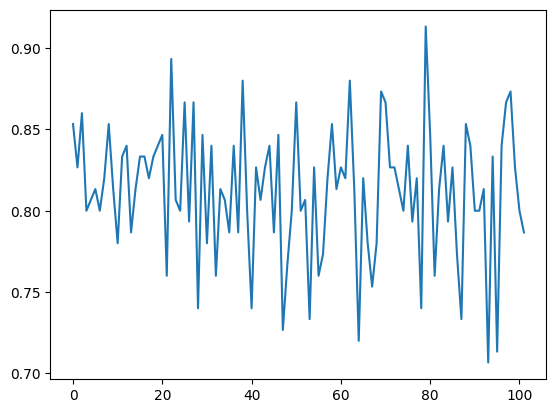

In [6]:
plt.plot(ssA)

In [7]:
jk = Jackknife( Nbin, binsize, ssA[nskip:] )
format_print(jk.mean(), jk.err())

'0.8116(41)'

In [8]:
jk = Jackknife( Nbin, binsize, ssA[nskip:] )
format_print(jk.mean(), jk.err())

'0.8116(41)'

In [9]:
jk = Jackknife( Nbin, binsize, ssB[nskip:] )
format_print(jk.mean(), jk.err())

'0.8152(40)'

In [10]:
jk = Jackknife( Nbin, binsize, ssC[nskip:] )
format_print(jk.mean(), jk.err())

'0.8185(36)'

In [2]:
def rearrange(corr_, Lx_, Ly_):
    lx_half=int(Lx_/2)
    ly_half=int(Ly_/2)
    tmp=[[corr_[(x-lx_half+Lx_)%Lx_,(y-ly_half+Ly_)%Ly_] for x in range(Lx_)] for y in range(Ly_)]
    return np.array(tmp)

jtheta(1, z, q, derivative=0):
$$
% \begin{array}
\vartheta_{n=1}(z,q) \equiv 2q^{1/4} \sum_{k\geq0} (-1)^k q^{k^2+k} \sin((2k+1) z)
% \end{array}
$$

jtheta(3, z, q, derivative=0):
$$
% \begin{array}
\vartheta_{n=3}(z,q) \equiv 1 + 2 \sum_{k\geq1} q^{k^2} \cos(2k z)
% \end{array}
$$

Relation between $q$ and $\tau$:
$$
q=e^{\tau \pi i}
$$

In [3]:
jtheta(1, 0.25, 0.2)

jtheta(3, 0.25, np.exp(-2.0*np.pi))

1.00327767036649

In [4]:
r=4

# Lx=16
# Lx=64
# Ly=r*Lx

# lx_half=int(Lx/2)
# ly_half=int(Ly/2)

In [5]:
directory="./data/"

ensemble32_id=str(32)+"_"+str(r*32)+"_1.000_1.000_0.000"
ensemble48_id=str(48)+"_"+str(r*48)+"_1.000_1.000_0.000"
ensemble64_id=str(64)+"_"+str(r*64)+"_1.000_1.000_0.000"

In [6]:
mag32_mean=np.loadtxt(directory+ensemble32_id+"_mag_mean.dat")
mag32_err =np.loadtxt(directory+ensemble32_id+"_mag_err.dat")

ex32_mean=np.loadtxt(directory+ensemble32_id+"_ex_mean.dat")
ex32_err =np.loadtxt(directory+ensemble32_id+"_ex_err.dat")

ey32_mean=np.loadtxt(directory+ensemble32_id+"_ey_mean.dat")
ey32_err =np.loadtxt(directory+ensemble32_id+"_ey_err.dat")

e32_mean=np.loadtxt(directory+ensemble32_id+"_e_mean.dat")
e32_err =np.loadtxt(directory+ensemble32_id+"_e_err.dat")

In [7]:
mag48_mean=np.loadtxt(directory+ensemble48_id+"_mag_mean.dat")
mag48_err =np.loadtxt(directory+ensemble48_id+"_mag_err.dat")

ex48_mean=np.loadtxt(directory+ensemble48_id+"_ex_mean.dat")
ex48_err =np.loadtxt(directory+ensemble48_id+"_ex_err.dat")

ey48_mean=np.loadtxt(directory+ensemble48_id+"_ey_mean.dat")
ey48_err =np.loadtxt(directory+ensemble48_id+"_ey_err.dat")

e48_mean=np.loadtxt(directory+ensemble48_id+"_e_mean.dat")
e48_err =np.loadtxt(directory+ensemble48_id+"_e_err.dat")

In [8]:
mag64_mean=np.loadtxt(directory+ensemble64_id+"_mag_mean.dat")
mag64_err =np.loadtxt(directory+ensemble64_id+"_mag_err.dat")

ex64_mean=np.loadtxt(directory+ensemble64_id+"_ex_mean.dat")
ex64_err =np.loadtxt(directory+ensemble64_id+"_ex_err.dat")

ey64_mean=np.loadtxt(directory+ensemble64_id+"_ey_mean.dat")
ey64_err =np.loadtxt(directory+ensemble64_id+"_ey_err.dat")

e64_mean=np.loadtxt(directory+ensemble64_id+"_e_mean.dat")
e64_err =np.loadtxt(directory+ensemble64_id+"_e_err.dat")

In [9]:
s_s32_mean=np.loadtxt(directory+ensemble32_id+"_s_s_mean.dat")
s_s32_err =np.loadtxt(directory+ensemble32_id+"_s_s_err.dat")

ex_ex32_mean=np.loadtxt(directory+ensemble32_id+"_ex_ex_mean.dat")
ex_ex32_err =np.loadtxt(directory+ensemble32_id+"_ex_ex_err.dat")

ey_ey32_mean=np.loadtxt(directory+ensemble32_id+"_ey_ey_mean.dat")
ey_ey32_err =np.loadtxt(directory+ensemble32_id+"_ey_ey_err.dat")

ex_ey32_mean=np.loadtxt(directory+ensemble32_id+"_ex_ey_mean.dat")
ex_ey32_err =np.loadtxt(directory+ensemble32_id+"_ex_ey_err.dat")

e_e32_mean=np.loadtxt(directory+ensemble32_id+"_e_e_mean.dat")
e_e32_err =np.loadtxt(directory+ensemble32_id+"_e_e_err.dat")

In [10]:
s_s48_mean=np.loadtxt(directory+ensemble48_id+"_s_s_mean.dat")
s_s48_err =np.loadtxt(directory+ensemble48_id+"_s_s_err.dat")

ex_ex48_mean=np.loadtxt(directory+ensemble48_id+"_ex_ex_mean.dat")
ex_ex48_err =np.loadtxt(directory+ensemble48_id+"_ex_ex_err.dat")

ey_ey48_mean=np.loadtxt(directory+ensemble48_id+"_ey_ey_mean.dat")
ey_ey48_err =np.loadtxt(directory+ensemble48_id+"_ey_ey_err.dat")

ex_ey48_mean=np.loadtxt(directory+ensemble48_id+"_ex_ey_mean.dat")
ex_ey48_err =np.loadtxt(directory+ensemble48_id+"_ex_ey_err.dat")

e_e48_mean=np.loadtxt(directory+ensemble48_id+"_e_e_mean.dat")
e_e48_err =np.loadtxt(directory+ensemble48_id+"_e_e_err.dat")

In [11]:
s_s64_mean=np.loadtxt(directory+ensemble64_id+"_s_s_mean.dat")
s_s64_err =np.loadtxt(directory+ensemble64_id+"_s_s_err.dat")

ex_ex64_mean=np.loadtxt(directory+ensemble64_id+"_ex_ex_mean.dat")
ex_ex64_err =np.loadtxt(directory+ensemble64_id+"_ex_ex_err.dat")

ey_ey64_mean=np.loadtxt(directory+ensemble64_id+"_ey_ey_mean.dat")
ey_ey64_err =np.loadtxt(directory+ensemble64_id+"_ey_ey_err.dat")

ex_ey64_mean=np.loadtxt(directory+ensemble64_id+"_ex_ey_mean.dat")
ex_ey64_err =np.loadtxt(directory+ensemble64_id+"_ex_ey_err.dat")

e_e64_mean=np.loadtxt(directory+ensemble64_id+"_e_e_mean.dat")
e_e64_err =np.loadtxt(directory+ensemble64_id+"_e_e_err.dat")

In [12]:
print("mag32:", mag32_mean, "+-", mag32_err)
print("mag48:", mag48_mean, "+-", mag48_err)
print("mag64:", mag64_mean, "+-", mag64_err)

mag32: 0.01576568603515625 +- 0.01304860285698269
mag48: 0.000411783854166695 +- 0.01242945687625397
mag64: -0.008397903442382813 +- 0.01188175080361912


In [13]:
# plt.matshow(np.log(s_s_mean), 
#             cmap="plasma")
# plt.contour(s_s_mean, np.arange(0,1,0.1))

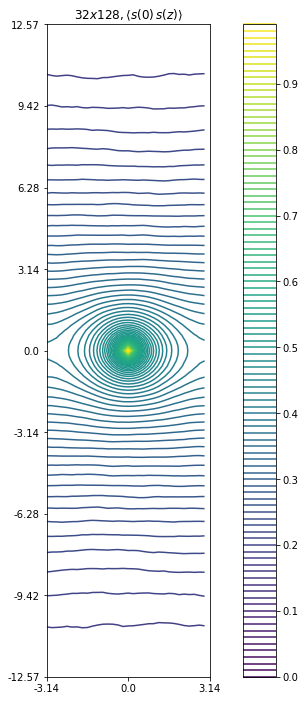

In [14]:
Lx=32; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=3
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s32_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

cont = ax.contour(tmp, np.arange(0,1, 0.01))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.set_aspect("equal", "box")
ax.set_title("$32x128, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/32_ss.eps", bbox_inches='tight')

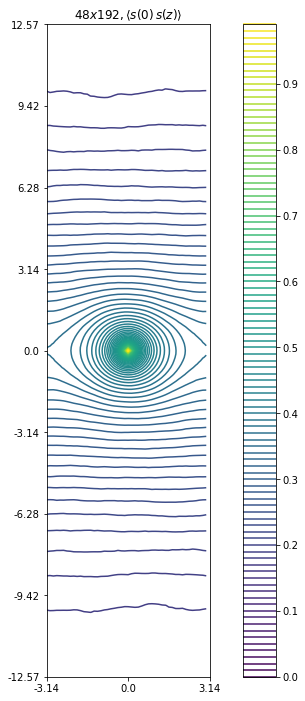

In [15]:
Lx=48; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=3
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s48_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

cont = ax.contour(tmp, np.arange(0,1, 0.01))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.set_aspect("equal", "box")
ax.set_title("$48x192, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/48_ss.eps", bbox_inches='tight')

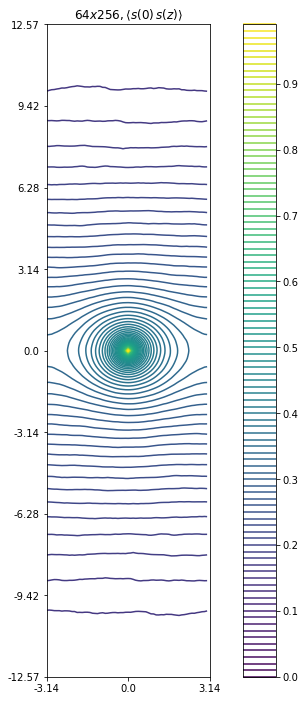

In [16]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=3
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

cont = ax.contour(tmp, np.arange(0,1, 0.01))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.set_aspect("equal", "box")
ax.set_title("$64x256, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/64_ss.eps", bbox_inches='tight')

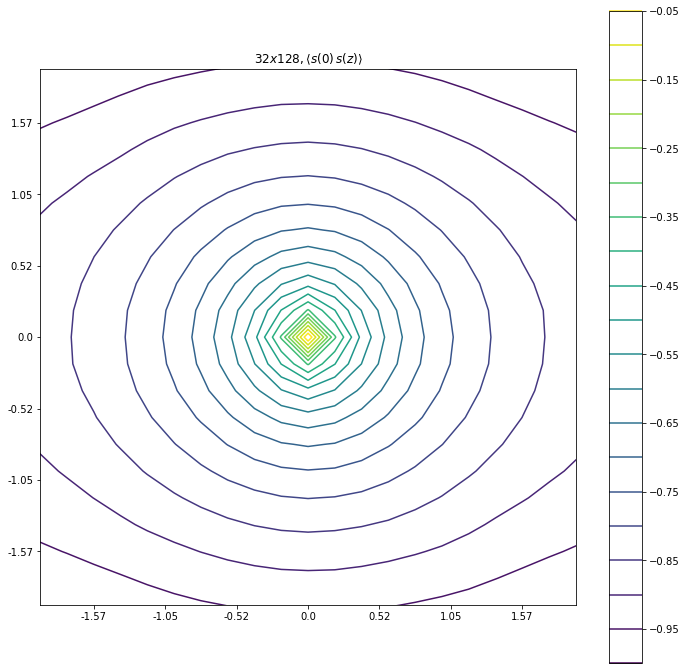

In [17]:
Lx=32; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=13
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s32_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

# cont = ax.contour(tmp, np.arange(0,0.9, 0.01))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-1, 0, 0.05))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)

ax.set_aspect("equal", "box")
ax.set_title("$32x128, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/32_ss_close.eps", bbox_inches='tight')

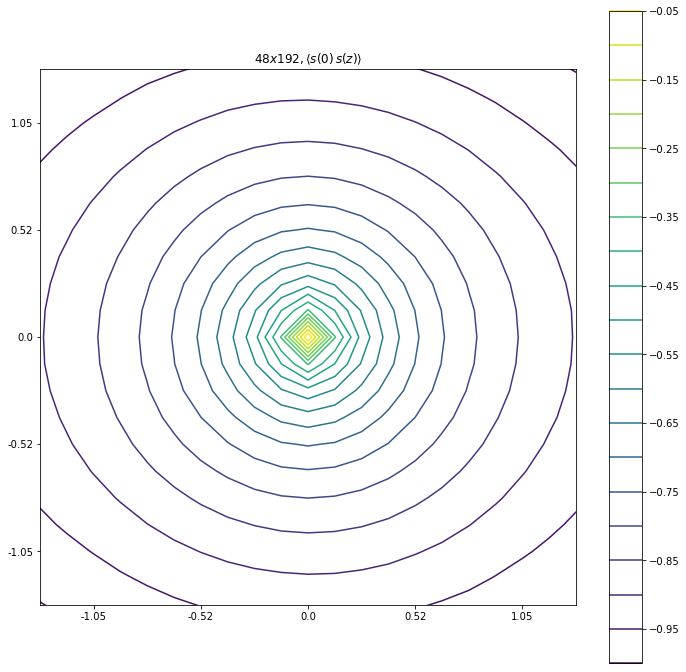

In [18]:
Lx=48; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=13
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s48_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

# cont = ax.contour(tmp, np.arange(0,0.9, 0.01))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-1, 0, 0.05))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)

ax.set_aspect("equal", "box")
ax.set_title("$48x192, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/48_ss_close.eps", bbox_inches='tight')

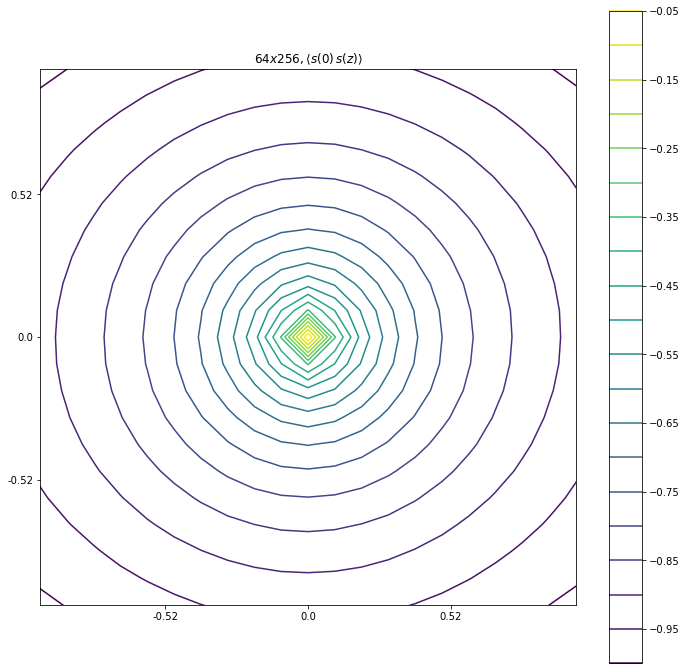

In [19]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

##

nptsx=13
nptsy=(nptsx-1)*r+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

##

tmp = rearrange(s_s64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )

# cont = ax.contour(tmp, np.arange(0,0.9, 0.01))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-1, 0, 0.05))
cbar = fig.colorbar( cont )

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)

ax.set_aspect("equal", "box")
ax.set_title("$64x256, \\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/64_ss_close.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[]

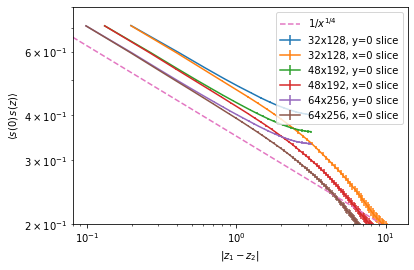

In [20]:
lx_half=16; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=s_s32_mean.T[0][1:lx_half]
dy=s_s32_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="32x128, y=0 slice")

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=s_s32_mean[0][1:ly_half]
dy=s_s32_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="32x128, x=0 slice")

#####

lx_half=24; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=s_s48_mean.T[0][1:lx_half]
dy=s_s48_err.T[0][1:lx_half]

plt.errorbar(x, y, dy, label="48x192, y=0 slice")

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=s_s48_mean[0][1:ly_half]
dy=s_s48_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="48x192, x=0 slice")

#####

lx_half=32; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=s_s64_mean.T[0][1:lx_half]
dy=s_s64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="64x256, y=0 slice")


x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=s_s64_mean[0][1:ly_half]
dy=s_s64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="64x256, x=0 slice")


###

x=np.arange(0.08, 10, 0.01)
y=1.0/x**(0.25)
plt.plot(x, 0.35*y, label="$1/x^{1/4}$", ls="dashed")

###

plt.xlim(0.8e-1, 14.0)
plt.ylim(2.0e-1, 0.8)

plt.legend()

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$|z_1-z_2|$")
plt.ylabel("$\\langle s(0) \, s(z) \\rangle$")

plt.savefig("fig/ss_slices.eps", bbox_inches='tight')
plt.plot()

In [21]:
font = {'family': 'sans-serif',
     'color': 'black',
     'weight': 'normal',
     'size': 14}

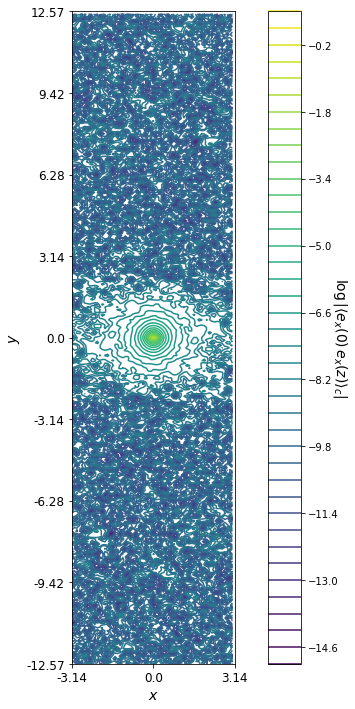

In [22]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=3
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ex_ex64_mean-ex64_mean**2, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_x(0) \, e_x(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

ax.set_aspect("equal", "box")

plt.savefig("fig/64_exex.eps", bbox_inches='tight')

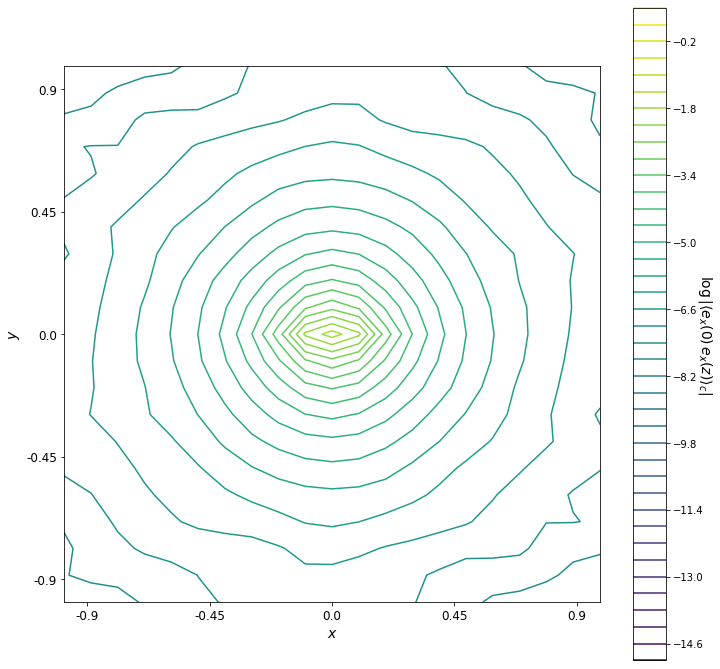

In [23]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=15
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ex_ex64_mean-ex64_mean**2, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_x(0) \, e_x(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)
ax.set_aspect("equal", "box")

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

plt.savefig("fig/64_exex_close.eps", bbox_inches='tight')

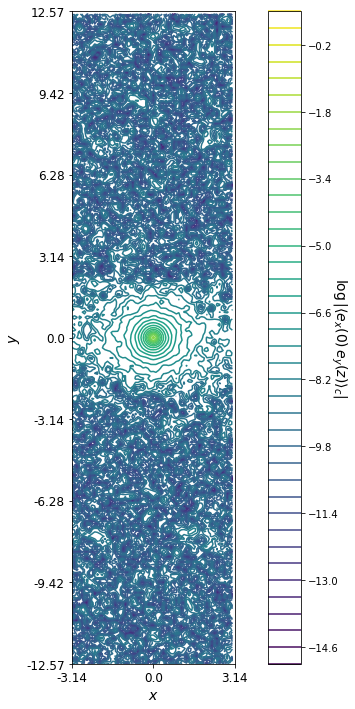

In [24]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=3
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ex_ey64_mean-ex64_mean*ey64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_x(0) \, e_y(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

ax.set_aspect("equal", "box")
plt.savefig("fig/64_exey.eps", bbox_inches='tight')

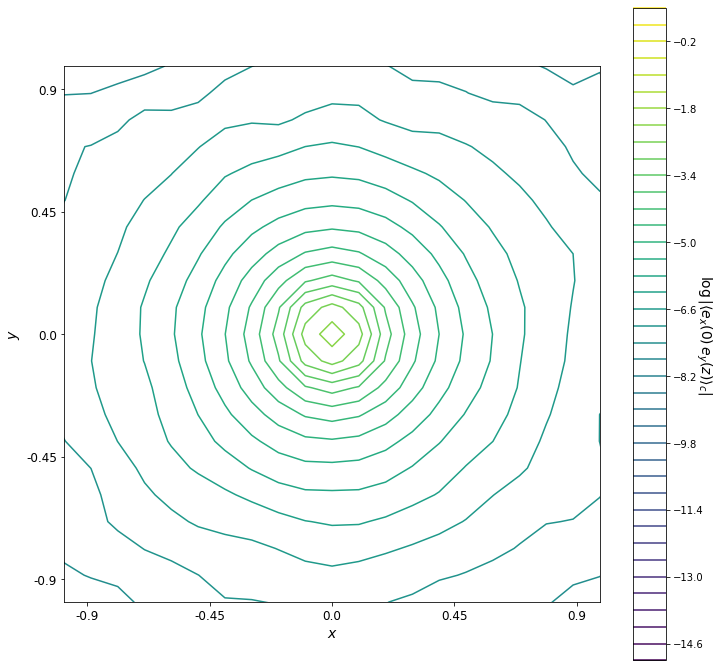

In [25]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=15
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ex_ey64_mean-ex64_mean*ey64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_x(0) \, e_y(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)
ax.set_aspect("equal", "box")

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

plt.savefig("fig/64_exey_close.eps", bbox_inches='tight')

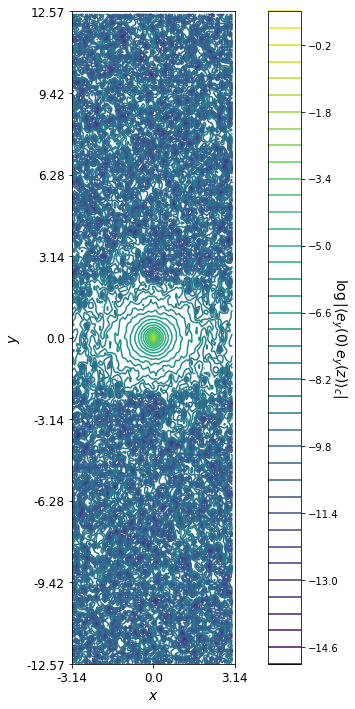

In [26]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=3
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ey_ey64_mean-ey64_mean*ey64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_y(0) \, e_y(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

ax.set_aspect("equal", "box")
plt.savefig("fig/64_eyey.eps", bbox_inches='tight')

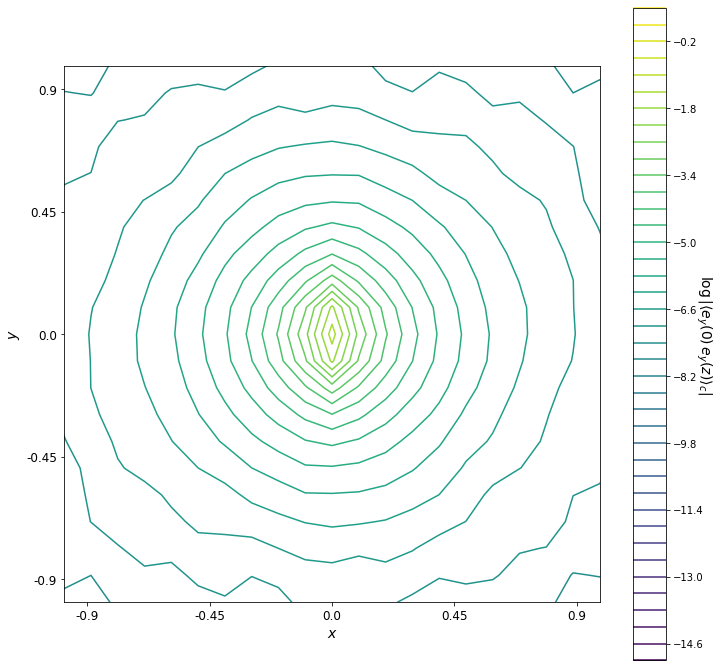

In [27]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=15
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(ey_ey64_mean-ey64_mean*ey64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e_y(0) \, e_y(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)
ax.set_aspect("equal", "box")

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

plt.savefig("fig/64_eyey_close.eps", bbox_inches='tight')

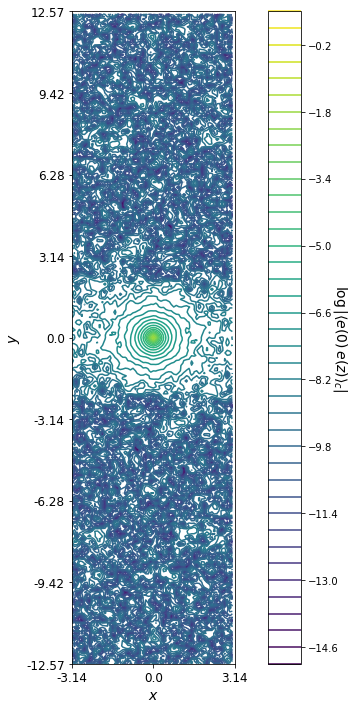

In [28]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=3
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(e_e64_mean-e64_mean*e64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e(0) \, e(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

ax.set_aspect("equal", "box")

plt.savefig("fig/64_ee.eps", bbox_inches='tight')

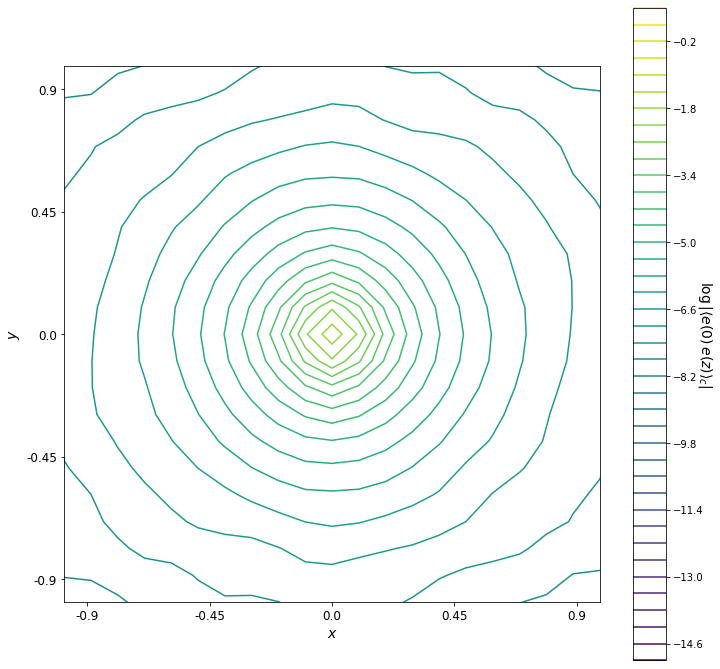

In [29]:
Lx=64; Ly=r*Lx
lx_half=int(Lx/2); ly_half=int(Ly/2)

nptsx=15
nptsy=r*(nptsx-1)+1

tkx = np.round(np.linspace(-np.pi, np.pi, nptsx), 2)
tky = np.round(np.linspace(-r*np.pi, r*np.pi, nptsy), 2)
ptx = np.linspace(0, Lx, nptsx)
pty = np.linspace(0, Ly, nptsy)

# ---------------

tmp = rearrange(e_e64_mean-e64_mean*e64_mean, Lx, Ly)

fig, ax = plt.subplots( figsize=(12,12) )
# cont = ax.contour(tmp, np.arange(0,1, 0.04))
cont = ax.contour(np.log(np.abs(tmp)), np.arange(-15, 1, 0.4))
cbar = fig.colorbar( cont )
cbar.set_label("$\\log \\vert \\langle e(0) \, e(z) \\rangle_c \\vert$",
              rotation=270, fontdict=font, labelpad=10)

ax.set_xticks(ptx)
ax.set_xticklabels(tkx)
ax.set_yticks(pty)
ax.set_yticklabels(tky)

delta=10

ax.set_xlim(lx_half-delta, lx_half+delta)
ax.set_ylim(ly_half-delta, ly_half+delta)
ax.set_aspect("equal", "box")

ax.tick_params(labelsize=12)
ax.set_xlabel("$x$", fontdict=font)
ax.set_ylabel("$y$", fontdict=font)

plt.savefig("fig/64_ee_close.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[]

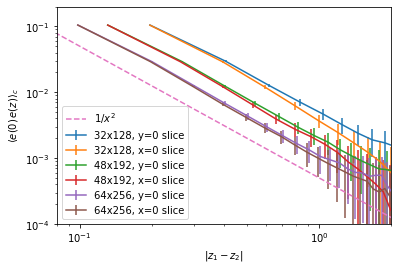

In [30]:
lx_half=16; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=e_e32_mean.T[0][1:lx_half]-e32_mean**2
dy=e_e32_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="32x128, y=0 slice")

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=e_e32_mean[0][1:ly_half]-e32_mean**2
dy=e_e32_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="32x128, x=0 slice")

#####

lx_half=24; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=e_e48_mean.T[0][1:lx_half]-e48_mean**2
dy=e_e48_err.T[0][1:lx_half]

plt.errorbar(x, y, dy, label="48x192, y=0 slice")

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=e_e48_mean[0][1:ly_half]-e48_mean**2
dy=e_e48_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="48x192, x=0 slice")

#####

lx_half=32; ly_half=r*lx_half

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=e_e64_mean.T[0][1:lx_half]-e64_mean**2
dy=e_e64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="64x256, y=0 slice")


x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=e_e64_mean[0][1:ly_half]-e64_mean**2
dy=e_e64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="64x256, x=0 slice")

###

x=np.arange(0.01, 10, 0.01)
y=1.0/x**(2.0)
plt.plot(x, 0.0005*y, label="$1/x^2$", ls="dashed")

###

plt.legend()

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$|z_1-z_2|$")
plt.ylabel("$\\langle e(0) \, e(z) \\rangle_c$")

plt.xlim(0.8e-1, 2.0)
plt.ylim(1.0e-4, 0.2)

plt.savefig("fig/ee_slices.eps", bbox_inches='tight')

plt.plot()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[]

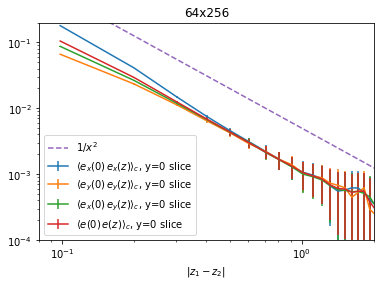

In [31]:
lx_half=32; ly_half=r*lx_half

###

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=ex_ex64_mean.T[0][1:lx_half]-ex64_mean**2
dy=ex_ex64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="$\\langle e_x(0) \, e_x(z) \\rangle_c$, y=0 slice")

###

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=ey_ey64_mean.T[0][1:lx_half]-ey64_mean**2
dy=ey_ey64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="$\\langle e_y(0) \, e_y(z) \\rangle_c$, y=0 slice")

###

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=ex_ey64_mean.T[0][1:lx_half]-ex64_mean*ey64_mean
dy=ex_ey64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="$\\langle e_x(0) \, e_y(z) \\rangle_c$, y=0 slice")

###

x=np.linspace(np.pi/lx_half, np.pi, lx_half-1)
y=e_e64_mean.T[0][1:lx_half]-e64_mean**2
dy=e_e64_err.T[0][1:lx_half]
plt.errorbar(x, y, dy, label="$\\langle e(0) \, e(z) \\rangle_c$, y=0 slice")

###

x=np.arange(0.01, 10, 0.01)
y=1.0/x**(2.0)
plt.plot(x, 0.005*y, label="$1/x^2$", ls="dashed")

###

plt.legend()

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$|z_1-z_2|$")
# plt.ylabel("$\\langle e(0) \, e(z) \\rangle_c$")
plt.title("64x256")

plt.xlim(0.8e-1, 2.0)
plt.ylim(1.0e-4, 0.2)

###

plt.savefig("fig/64_ees_y0slice.eps", bbox_inches='tight')

plt.plot()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[]

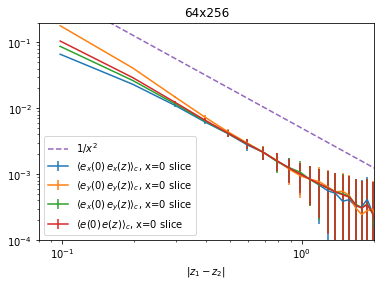

In [32]:
lx_half=32; ly_half=r*lx_half

###

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=ex_ex64_mean[0][1:ly_half]-ex64_mean**2
dy=ex_ex64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="$\\langle e_x(0) \, e_x(z) \\rangle_c$, x=0 slice")

###

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=ey_ey64_mean[0][1:ly_half]-ey64_mean**2
dy=ey_ey64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="$\\langle e_y(0) \, e_y(z) \\rangle_c$, x=0 slice")

###

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=ex_ey64_mean[0][1:ly_half]-ex64_mean*ey64_mean
dy=ex_ey64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="$\\langle e_x(0) \, e_y(z) \\rangle_c$, x=0 slice")

###

x=np.linspace(r*np.pi/ly_half, r*np.pi, ly_half-1)
y=e_e64_mean[0][1:ly_half]-e64_mean**2
dy=e_e64_err[0][1:ly_half]
plt.errorbar(x, y, dy, label="$\\langle e(0) \, e(z) \\rangle_c$, x=0 slice")

###

x=np.arange(0.01, 10, 0.01)
y=1.0/x**(2.0)
plt.plot(x, 0.005*y, label="$1/x^2$", ls="dashed")

###

plt.legend()

plt.xscale("log")
plt.yscale("log")

plt.xlabel("$|z_1-z_2|$")
# plt.ylabel("$\\langle e(0) \, e(z) \\rangle_c$")
plt.title("64x256")

plt.xlim(0.8e-1, 2.0)
plt.ylim(1.0e-4, 0.2)

plt.savefig("fig/64_ees_x0slice.eps", bbox_inches='tight')

plt.plot()